In [1]:
# !pip3 install shap
# !pip3 install pyexplainer
# !pip3 install lime
# !pip3 install gensim
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install sklearn
# !pip3 install nltk
# import nltk
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# !pip install wordcloud

In [2]:
import numpy as np
import json, re, nltk, string, os, sys
from os.path import abspath
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from keras.utils import np_utils
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import time

In [3]:
bug_reports = os.path.join(sys.path[0],"data/GoogleChromium/train_test_json/classifier_data_20.json")
deep_data = os.path.join(sys.path[0],"data/GoogleChromium/deep_data.json")

In [4]:
#========================================================================================
# Initializing Hyper parameter
#========================================================================================
#1. Word2vec parameters
min_word_frequency = 5
embed_size_word2vec = 300
context_window_word2vec = 5

#2. Classifier hyperparameters
numCV = 10
max_sentence_len = 50
min_sentence_length = 15
rankK = 10
batch_size = 32

In [5]:
def contains_letters(phrase):
    return bool(re.search('[a-zA-Z]', phrase))

In [6]:
def getProcessedData(bug_reports):
    with open(bug_reports) as data_file:
        data = json.load(data_file, strict=False)

    i = 0
    
    raw_data = []
    all_data = []
    all_owner = []
    for item in data:
        
        data = 'Title:' + item['issue_title'] + '\n Description: ' + item['description']
        raw_data.append(data) 

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)
        all_owner.append(item['owner'])
        
        i = i + 1
        if i == 20000:
            break

    return raw_data, all_data, all_owner

In [7]:
raw_data, all_data, all_owner = getProcessedData(bug_reports)

In [8]:
len(raw_data)
len(all_data)
len(all_owner)

20000

In [9]:
def getRandomForestClassifierAccuracy(X_train, Y_train, X_test, Y_test):
    start = time.time()

    rfc_model = RandomForestClassifier(n_estimators = 1000, max_depth = 300, n_jobs = -1, random_state=1)
    
    rfc_model.fit(X_train, Y_train) 
    
    y_pred = rfc_model.predict_proba(X_test)
    
    end = time.time()
    
    elapsedTime = end - start
    
    classes = rfc_model.classes_
    sortedIndices = []
    pred_classes = []
    index_pred_classes = []
    rfc_accuracy = []
    index = 0  
    for ll in y_pred:
        sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))  
    for k in range(1, rankK+1):
        id = 0
        trueNum = 0
        pred_class_no=0
        for sortedInd in sortedIndices:
            if Y_test[id] in classes[sortedInd[:k]]:
                trueNum += 1
                pred_classes.append(classes[sortedInd[:k]])
                pred_class_no = trueNum
                if index < 9 and k == 1:
                    index = id
                    index_pred_classes.append(classes[sortedInd[:k]])
            id += 1
        rfc_accuracy.append(float('{0:.2f}'.format((float(trueNum) / len(y_pred)) * 100)))

    return rfc_model, rfc_accuracy, classes, index, elapsedTime

In [10]:
def average(lst):
    return sum(lst) / len(lst)

In [11]:
def getRank1_5_10_data(accuracy_cv10_with_avg):
    rank1=''
    rank5=''
    rank10=''
    for i in range(0, 11):
        rank1 = rank1 + str(accuracy_cv10_with_avg[i][0])
        rank5 = rank5 + str(accuracy_cv10_with_avg[i][4])
        rank10 = rank10 + str(accuracy_cv10_with_avg[i][9])

        if i!=10:
            rank1 = rank1 + '  '
            rank5 = rank5 + '  '
            rank10 = rank10 + '  '


    return rank1, rank5, rank10

In [12]:
def getProcessedDeepData(deep_data):
    with open(deep_data) as data_file:
        data = json.load(data_file, strict=False)

    all_data = []
    for item in data:

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
 
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)

    return all_data

In [13]:
def getSynonyms(word):
    synonyms = []
    synsets = wordnet.synsets(word)
    if (len(synsets) == 0):
        return []
    synset = synsets[0]
    lemma_names = synset.lemma_names()
    for lemma_name in lemma_names:
        lemma_name = lemma_name.lower().replace('_', ' ')
        if (lemma_name != word and lemma_name not in synonyms):
            synonyms.append(lemma_name)
    return set(synonyms)

In [14]:
def makeFeatureVecWithWordNet(bugReport, model, num_features, list_of_syn_data):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    synCounter = 0
    norCounter = 0
    elseTest = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            norCounter = norCounter+1
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
        else:
            elseTest = elseTest + 1
            for synonym in getSynonyms(word):
                if synonym in index2word_set:
                    list_of_syn_data.append(word + ' : ' + synonym)
                    synCounter = synCounter + 1
                    nwords = nwords + 1
                    featureVec = np.add(featureVec, model.wv[synonym])
                    found = True
                    break
            if nwords == max_sentence_len-1:
                break
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return elseTest, synCounter, norCounter, featureVec


def getAvgFeatureVecsWithWordNet(bugReports, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    synonymCounter = 0
    normalCounter = 0
    elseTest1=0
    list_of_syn_data = []
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for bugReport in bugReports:
        # Call the function (defined above) that makes average feature vectors
        elseTest, synCounter, norCounter, bugReportsVecs[counter] = makeFeatureVecWithWordNet(
            bugReport, model, num_features, list_of_syn_data)
        
        synonymCounter = synonymCounter + synCounter 
        normalCounter = normalCounter + norCounter
        elseTest1 = elseTest1 + elseTest
        #
        # Increment the counter
        counter = counter + 1
        
    print('elseTest1,', elseTest1)
#     print('list_of_syn_data,', list_of_syn_data)
    return synonymCounter, normalCounter, bugReportsVecs


In [15]:
def makeFeatureVec(bugReport, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(bugReports, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the bugreport
    for bugReport in bugReports:
        # Call the function (defined above) that makes average feature vectors
        bugReportsVecs[counter] = makeFeatureVec(bugReport, model, num_features)
        #
        # Increment the counter
        counter = counter + 1
    return bugReportsVecs

In [16]:
deep_data_list = getProcessedDeepData(deep_data)

In [17]:
def getFilteredDataForWordnet(train_data, test_data, vocabulary):
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    train_word_count = 0
    test_word_count = 0
    updated_train_word_count = 0
    updated_test_word_count = 0
    
    for j, item in enumerate(train_data):
        train_word_count = train_word_count + len(item)
        current_train_filter = [word for word in item if word in vocabulary or set(getSynonyms(word)).intersection(vocabulary)]
        updated_train_word_count = updated_train_word_count + len(current_train_filter)
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, item in enumerate(test_data):
        test_word_count = test_word_count + len(item)
        current_test_filter = [word for word in item if word in vocabulary or set(getSynonyms(word)).intersection(vocabulary)]
        updated_test_word_count = updated_test_word_count + len(current_test_filter)
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])
            
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))
    
    return updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count


In [18]:
def getFilteredData(train_data, test_data, vocabulary):
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    train_word_count = 0
    test_word_count = 0
    updated_train_word_count = 0
    updated_test_word_count = 0
    
    for j, item in enumerate(train_data): 
        train_word_count = train_word_count + len(item)
        current_train_filter = [word for word in item if word in vocabulary]
        updated_train_word_count = updated_train_word_count + len(current_train_filter)
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, item in enumerate(test_data):
        test_word_count = test_word_count + len(item)
        current_test_filter = [word for word in item if word in vocabulary]
        updated_test_word_count = updated_test_word_count + len(current_test_filter)
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])
            
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))
    
    return updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count

In [19]:
totalLength = len(all_data)
trainingTestingLength = totalLength / (numCV + 1)

rfc_accuracy_cv10 = []
m_accuracy_cv10 = []
nn_accuracy_cv10 = []
rfc_accuracy_with_wordnet_cv10 = []
m_accuracy_with_wordnet_cv10 = []
nn_accuracy_with_wordnet_cv10 = []
rfc_with_wordnet_elapsed_time_cv10 = []
mlp_with_wordnet_elapsed_time_cv10 = []
rfc_elapsed_time_cv10 = []
mlp_elapsed_time_cv10 = []
nn_elapsed_time_cv10 = []

train_word_count_for_wordnet = []
updated_train_word_count_for_wordnet = []
test_word_count_for_wordnet = []
updated_test_word_count_for_wordnet = []
synonymCounter_training_for_wordnet = []
normalCounter_training_for_wordnet = []
synonymCounter_test_for_wordnet = []
normalCounter_test_for_wordnet = []

train_word_count_without_wordnet = []
updated_train_word_count_without_wordnet = []
test_word_count_without_wordnet = []
updated_test_word_count_without_wordnet = []


for i in range(1, numCV+1):
    # Split cross validation set
    print(i)
    raw_train_data = raw_data[:int(i*trainingTestingLength)]
    raw_test_data = raw_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_data = all_data[:int(i*trainingTestingLength)]
    test_data = all_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_owner = all_owner[:int(i*trainingTestingLength)]
    test_owner = all_owner[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    
    print(len(raw_train_data))
    print(len(raw_test_data))
    print(len(train_data))
    print(len(test_data))
    print(len(train_owner))
    print(len(test_owner))
    
    data_for_word_2_vec = deep_data_list + train_data
    
    print(len(data_for_word_2_vec))
    
    wordvec_model = Word2Vec(data_for_word_2_vec, min_count=min_word_frequency, vector_size=embed_size_word2vec, window=context_window_word2vec)
    vocabulary = set(wordvec_model.wv.index_to_key)
    vocab_size = len(vocabulary)
    
    print(vocab_size)
    
    
    updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count = getFilteredDataForWordnet(train_data, test_data, vocabulary)
    
    synonymCounter_training = 0
    normalCounter_training = 0
    
    synonymCounter_training, normalCounter_training, X_matrix_train = getAvgFeatureVecsWithWordNet(updated_train_data, wordvec_model, embed_size_word2vec)
    
    print('with wordnet')
    print('train_word_count : ', train_word_count)
    print('updated_train_word_count : ', updated_train_word_count)
    print('removed_train_word_count : ', train_word_count - updated_train_word_count)
    print('synonymCounter_training : ', synonymCounter_training)
    print('normalCounter_training : ', normalCounter_training)
    
    synonymCounter_testing = 0
    normalCounter_testing = 0
    
    synonymCounter_testing, normalCounter_testing, X_matrix_test = getAvgFeatureVecsWithWordNet(updated_test_data, wordvec_model, embed_size_word2vec)
    
    print('test_word_count : ', test_word_count)
    print('updated_test_word_count : ', updated_test_word_count)
    print('removed_test_word_count : ', test_word_count - updated_test_word_count)
    print('synonymCounter_testing : ', synonymCounter_testing)
    print('normalCounter_testing : ', normalCounter_testing)
    
    train_word_count_for_wordnet.append(train_word_count)
    updated_train_word_count_for_wordnet.append(updated_train_word_count)
    test_word_count_for_wordnet.append(test_word_count)
    updated_test_word_count_for_wordnet.append(updated_test_word_count)
    synonymCounter_training_for_wordnet.append(synonymCounter_training)
    normalCounter_training_for_wordnet.append(normalCounter_training)
    synonymCounter_test_for_wordnet.append(synonymCounter_testing)
    normalCounter_test_for_wordnet.append(normalCounter_testing)
    
    
    randomForestClassifier, rfc_accuracy_with_wordnet, classes, rfc_index_with_wordnet_cv10, rfc_with_wordnet_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, updated_train_owner, 
                                                                      X_matrix_test, updated_test_owner)
    

    print('Random Forest Classifier Accuracy(With Wordnet) : ', rfc_accuracy_with_wordnet)
    
    del randomForestClassifier
    
    updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count = getFilteredData(train_data, test_data, vocabulary)
    
    X_matrix_train = getAvgFeatureVecs(updated_train_data, wordvec_model, embed_size_word2vec)
    X_matrix_test = getAvgFeatureVecs(updated_test_data, wordvec_model, embed_size_word2vec)
    
    print('without wordnet')
    print('train_word_count : ', train_word_count)
    print('updated_train_word_count : ', updated_train_word_count)
    print('removed_train_word_count : ', train_word_count - updated_train_word_count)
    print('test_word_count : ', test_word_count)
    print('updated_test_word_count : ', updated_test_word_count)
    print('removed_test_word_count : ', test_word_count - updated_test_word_count)
    
    train_word_count_without_wordnet.append(train_word_count)
    updated_train_word_count_without_wordnet.append(updated_train_word_count)
    test_word_count_without_wordnet.append(test_word_count)
    updated_test_word_count_without_wordnet.append(updated_test_word_count)
    
    
    randomForestClassifier, rfc_accuracy, classes, rfc_index_cv10, rfc_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, 
                                                                              updated_train_owner, 
                                                                              X_matrix_test, 
                                                                              updated_test_owner)
    

    print('Random Forest Classifier Accuracy : ', rfc_accuracy)

    del randomForestClassifier
    
    rfc_accuracy_cv10.append(rfc_accuracy)
    rfc_accuracy_with_wordnet_cv10.append(rfc_accuracy_with_wordnet)
    
    
    rfc_with_wordnet_elapsed_time_cv10.append(rfc_with_wordnet_elapsed_time)
    rfc_elapsed_time_cv10.append(rfc_elapsed_time)
    

1
1818
1818
1818
1818
1818
1818
165513
58795
elseTest1, 49
with wordnet
train_word_count :  157440
updated_train_word_count :  150058
removed_train_word_count :  7382
synonymCounter_training :  49
normalCounter_training :  65486
elseTest1, 65
test_word_count :  153423
updated_test_word_count :  141784
removed_test_word_count :  11639
synonymCounter_testing :  65
normalCounter_testing :  56795
Random Forest Classifier Accuracy(With Wordnet) :  [12.02, 16.62, 20.37, 22.84, 25.04, 26.38, 27.65, 28.78, 29.7, 30.62]
without wordnet
train_word_count :  157440
updated_train_word_count :  149979
removed_train_word_count :  7461
test_word_count :  153423
updated_test_word_count :  141667
removed_test_word_count :  11756
Random Forest Classifier Accuracy :  [12.31, 16.7, 20.03, 21.87, 24.2, 26.19, 27.53, 29.02, 30.71, 31.49]
2
3636
1818
3636
1818
3636
1818
167331
59700
elseTest1, 103
with wordnet
train_word_count :  310863
updated_train_word_count :  297234
removed_train_word_count :  13629
syno

Random Forest Classifier Accuracy :  [11.39, 17.31, 21.73, 25.22, 28.58, 30.82, 32.81, 34.74, 35.93, 36.99]


In [20]:
print('train_word_count_for_wordnet: ', train_word_count_for_wordnet)
print('updated_train_word_count_for_wordnet: ', updated_train_word_count_for_wordnet)
print('test_word_count_for_wordnet: ', test_word_count_for_wordnet)
print('updated_test_word_count_for_wordnet: ', updated_test_word_count_for_wordnet)
print('synonymCounter_training_for_wordnet: ', synonymCounter_training_for_wordnet)
print('normalCounter_training_for_wordnet: ', normalCounter_training_for_wordnet)
print('synonymCounter_test_for_wordnet: ', synonymCounter_test_for_wordnet)
print('normalCounter_test_for_wordnet: ', normalCounter_test_for_wordnet)

print('train_word_count_without_wordnet: ',train_word_count_without_wordnet)
print('updated_train_word_count_without_wordnet: ', updated_train_word_count_without_wordnet)
print('test_word_count_without_wordnet: ',test_word_count_without_wordnet)
print('updated_test_word_count_without_wordnet: ', updated_test_word_count_without_wordnet)

train_word_count_for_wordnet:  [157440, 310863, 468127, 620243, 780881, 950598, 1109794, 1264331, 1412950, 1556371]
updated_train_word_count_for_wordnet:  [150058, 297234, 448117, 594639, 749227, 913661, 1067301, 1216845, 1360274, 1499082]
test_word_count_for_wordnet:  [153423, 157264, 152116, 160638, 169717, 159196, 154537, 148619, 143421, 149952]
updated_test_word_count_for_wordnet:  [141784, 145575, 141436, 149409, 158577, 148571, 145201, 139275, 134895, 140919]
synonymCounter_training_for_wordnet:  [49, 103, 153, 200, 251, 295, 343, 385, 426, 452]
normalCounter_training_for_wordnet:  [65486, 130304, 193817, 258915, 325359, 391761, 456841, 522034, 583914, 647926]
synonymCounter_test_for_wordnet:  [65, 58, 62, 66, 75, 61, 67, 61, 51, 86]
normalCounter_test_for_wordnet:  [56795, 60038, 62867, 63973, 64294, 63612, 64247, 60731, 63001, 62927]
train_word_count_without_wordnet:  [157440, 310863, 468127, 620243, 780881, 950598, 1109794, 1264331, 1412950, 1556371]
updated_train_word_count_w

In [21]:
print(rfc_accuracy_cv10)

[[12.31, 16.7, 20.03, 21.87, 24.2, 26.19, 27.53, 29.02, 30.71, 31.49], [10.32, 16.02, 19.19, 22.04, 24.62, 26.27, 28.46, 29.72, 30.51, 31.37], [10.49, 15.86, 20.27, 24.42, 26.92, 29.03, 30.88, 32.54, 34.46, 35.93], [10.75, 16.92, 21.06, 23.85, 26.53, 27.61, 29.33, 31.42, 33.33, 35.05], [10.33, 16.97, 21.54, 25.42, 27.3, 29.3, 31.18, 32.5, 33.88, 35.19], [12.3, 17.85, 21.07, 23.66, 26.31, 28.58, 30.16, 31.42, 32.87, 33.82], [10.74, 16.36, 19.86, 23.05, 25.67, 27.98, 29.92, 31.79, 32.79, 33.85], [10.44, 16.76, 21.66, 23.98, 25.92, 28.76, 30.63, 32.43, 33.59, 35.14], [13.0, 19.06, 23.88, 27.31, 30.19, 32.19, 34.06, 35.5, 37.31, 38.25], [11.39, 17.31, 21.73, 25.22, 28.58, 30.82, 32.81, 34.74, 35.93, 36.99]]


In [22]:
rfc_accuracy_cv10_with_avg = rfc_accuracy_cv10

In [23]:
print(rfc_accuracy_with_wordnet_cv10)

[[12.02, 16.62, 20.37, 22.84, 25.04, 26.38, 27.65, 28.78, 29.7, 30.62], [11.44, 16.47, 20.04, 22.88, 25.73, 27.25, 28.44, 29.56, 30.89, 32.14], [10.4, 16.15, 20.61, 23.74, 26.1, 28.02, 30.06, 31.72, 33.38, 34.65], [10.18, 16.22, 20.8, 24.05, 26.65, 29.07, 31.11, 32.63, 33.97, 34.99], [10.77, 16.66, 20.66, 23.67, 26.74, 29.43, 31.5, 33.19, 34.38, 35.44], [12.17, 17.84, 21.75, 24.78, 27.18, 28.56, 30.26, 31.78, 33.48, 35.31], [10.79, 16.34, 20.21, 23.33, 26.08, 28.45, 30.38, 31.69, 33.94, 35.5], [10.82, 17.72, 22.04, 24.74, 27.38, 29.06, 31.31, 32.41, 33.57, 35.24], [12.19, 18.81, 23.69, 26.94, 29.19, 31.56, 33.69, 35.31, 36.94, 38.31], [11.52, 18.37, 22.48, 25.84, 28.27, 30.64, 32.81, 34.37, 35.31, 36.92]]


In [24]:
rfc_accuracy_with_wordnet_cv10_with_avg = rfc_accuracy_with_wordnet_cv10

In [25]:
rfc_accuracy_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_cv10)]
rfc_accuracy_with_wordnet_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_with_wordnet_cv10)]

In [26]:
print(rfc_accuracy_avg)

[11.21, 16.98, 21.03, 24.08, 26.62, 28.67, 30.5, 32.11, 33.54, 34.71]


In [27]:
print(rfc_accuracy_with_wordnet_avg)

[11.23, 17.12, 21.26, 24.28, 26.84, 28.84, 30.72, 32.14, 33.56, 34.91]


In [28]:
rfc_accuracy_cv10_with_avg.append(rfc_accuracy_avg)

In [29]:
rfc_accuracy_with_wordnet_cv10_with_avg.append(rfc_accuracy_with_wordnet_avg)

In [30]:
rfc_accuracy_cv10_with_avg_rank1, rfc_accuracy_cv10_with_avg_rank5, rfc_accuracy_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_cv10_with_avg)         
    
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

12.31  10.32  10.49  10.75  10.33  12.3  10.74  10.44  13.0  11.39  11.21
24.2  24.62  26.92  26.53  27.3  26.31  25.67  25.92  30.19  28.58  26.62
31.49  31.37  35.93  35.05  35.19  33.82  33.85  35.14  38.25  36.99  34.71


In [31]:
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

12.31  10.32  10.49  10.75  10.33  12.3  10.74  10.44  13.0  11.39  11.21
24.2  24.62  26.92  26.53  27.3  26.31  25.67  25.92  30.19  28.58  26.62
31.49  31.37  35.93  35.05  35.19  33.82  33.85  35.14  38.25  36.99  34.71


In [32]:
rfc_accuracy_with_wordnet_cv10_with_avg_rank1, rfc_accuracy_with_wordnet_cv10_with_avg_rank5, rfc_accuracy_with_wordnet_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_with_wordnet_cv10_with_avg)         
    
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank1)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank5)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank10)

12.02  11.44  10.4  10.18  10.77  12.17  10.79  10.82  12.19  11.52  11.23
25.04  25.73  26.1  26.65  26.74  27.18  26.08  27.38  29.19  28.27  26.84
30.62  32.14  34.65  34.99  35.44  35.31  35.5  35.24  38.31  36.92  34.91


In [33]:
rfc_with_wordnet_elapsed_time_cv10

[56.723308086395264,
 143.9527988433838,
 242.3215320110321,
 328.6670198440552,
 450.5411717891693,
 588.6379120349884,
 715.6844160556793,
 841.7921380996704,
 960.3720121383667,
 1101.5880291461945]

In [34]:
print(np.mean(rfc_with_wordnet_elapsed_time_cv10))

543.0280338048935


In [35]:
rfc_elapsed_time_cv10

[55.247485876083374,
 144.85864424705505,
 242.10588788986206,
 329.70291900634766,
 454.61587595939636,
 597.0533602237701,
 722.6414520740509,
 843.1550831794739,
 953.789076089859,
 1107.5043931007385]

In [36]:
print(np.mean(rfc_elapsed_time_cv10))

545.0674177646637


In [37]:
print(rfc_accuracy_avg)

[11.21, 16.98, 21.03, 24.08, 26.62, 28.67, 30.5, 32.11, 33.54, 34.71]


In [38]:
print(rfc_accuracy_with_wordnet_avg)

[11.23, 17.12, 21.26, 24.28, 26.84, 28.84, 30.72, 32.14, 33.56, 34.91]


In [39]:
rfc_accuracy_avg = [11.21, 16.98, 21.03, 24.08, 26.62, 28.67, 30.5, 32.11, 33.54, 34.71]
rfc_accuracy_with_wordnet_avg = [11.23, 17.12, 21.26, 24.28, 26.84, 28.84, 30.72, 32.14, 33.56, 34.91]

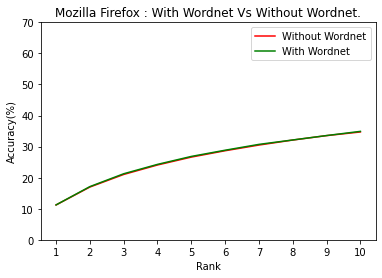

In [40]:
# x = range(1,12)
y = range(0,70)

plt.plot(rfc_accuracy_avg, color='red',label ='Without Wordnet')
plt.plot(rfc_accuracy_with_wordnet_avg, color='green',label ='With Wordnet')
plt.title('Google Chromium : With Wordnet Vs Without Wordnet.')
plt.xlabel('Rank')
plt.ylabel('Accuracy(%)')
plt.xticks([r for r in range(10)],
        ['1', '2', '3', '4', '5','6', '7', '8', '9', '10'])
plt.yticks(np.arange(0, 80, 10))
plt.legend()
# plt.show()

plt.savefig('rf_word2vec_gc_with_or_without_wordnet.png')

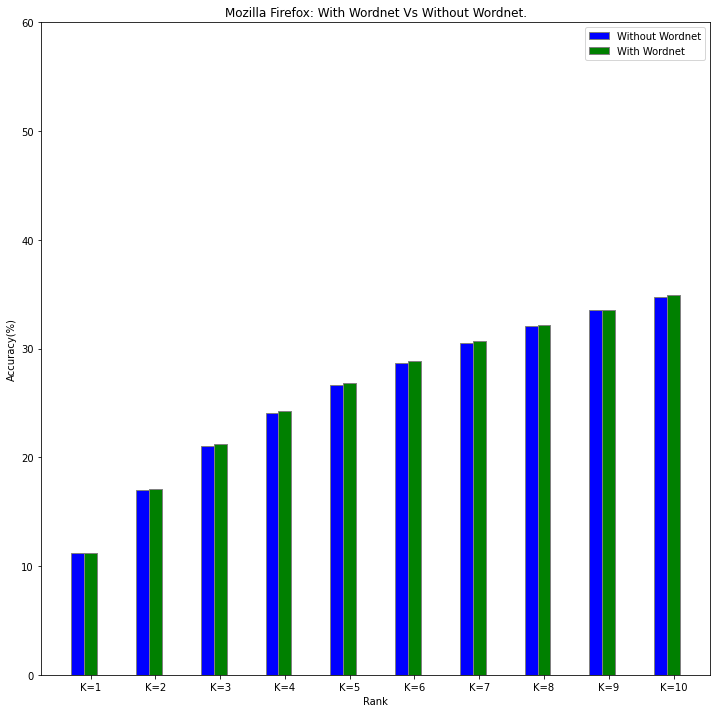

In [41]:
y = range(0,70)
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 12))
 
# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, rfc_accuracy_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='Without Wordnet')
plt.bar(br2, rfc_accuracy_with_wordnet_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='With Wordnet')
 
# Adding Xticks
plt.xlabel('Rank')
plt.ylabel('Accuracy(%)')
plt.xticks([r + barWidth for r in range(10)],
       ['K=1', 'K=2', 'K=3', 'K=4', 'K=5', 'K=6', 'K=7', 'K=8', 'K=9', 'K=10'])
plt.yticks(np.arange(0, 70, 10))

plt.title('Google Chromium: With Wordnet Vs Without Wordnet.')
 
plt.legend()

# plt.show()

plt.savefig('gc_rf_with_or_without_wordnet.png')

In [42]:
rfc_accuracy_avg_rank = []
rfc_accuracy_with_wordnet_avg_rank = []

rfc_accuracy_avg_rank.append(rfc_accuracy_avg[0])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[4])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[9])

rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[0])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[4])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[9])

In [43]:
print(rfc_accuracy_avg_rank)
print(rfc_accuracy_with_wordnet_avg_rank)

[11.21, 26.62, 34.71]
[11.23, 26.84, 34.91]


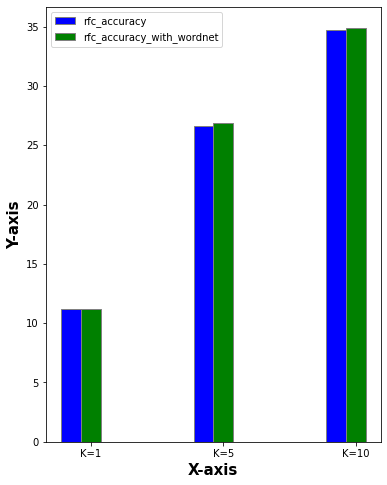

In [44]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(6, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


# Make the plot
plt.bar(br1, rfc_accuracy_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br2, rfc_accuracy_with_wordnet_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy with or without wordnet (Rank 1, 5 and 10): BiDirectional Neural Network')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_Random_Forest_with_or_without_wordnet_bar_rank_gc.png')